In [1]:
# Use Erdos_Spring_2025 conda env as created
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import shap


In [2]:
fname = 'data/dry_eye_disease_parsed.csv'
df0 = pd.read_csv(fname)

In [3]:
df = df0.copy()
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
             'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'combined_condition']
df = df.drop(columns=omit_cols)

['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition']


In [8]:
def feature_selection(df, col):
    target_col = col 
    y = df[target_col]
    #Drop the target columns, so the rest are feature columns
    X = df.drop(columns=target_col)
    
    # Splitting into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define XGBoost model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    param_grid = {
        'n_estimators': [50, 100, 200, 300, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }
    
    # Perform Grid Search
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                            cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    
    # Get best parameters
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    
    # Train final model with best parameters
    best_xgb = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
    best_xgb.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = best_xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Test MSE:", mse)
    
    # Feature Importance
    feature_names = X.columns.tolist()
    importance = best_xgb.feature_importances_
    f_pairs = list(zip(importance, feature_names))
    f_pairs.sort()
    importance_sort, feature_names_sort = zip(*f_pairs)
    max_imp = importance.max()
    print(max_imp)
    plt.figure(figsize=(10,6))
    plt.barh(list(feature_names_sort), list(importance_sort))
    plt.xlabel("Feature Importance/Feature Max")
    plt.ylabel("Features")
    plt.title("XGBoost Feature Importance")
    plt.xscale('log')
    plt.show()
    plt.clf()
    
    # # SHAP values for feature selection
    # explainer = shap.Explainer(best_xgb)
    # shap_values = explainer(X_train)
    # shap.summary_plot(shap_values, X_train, feature_names=feature_names)

python(15608) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15609) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15610) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15611) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15612) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15613) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15614) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15615) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Test MSE: 0.20976199209690094
0.29861248


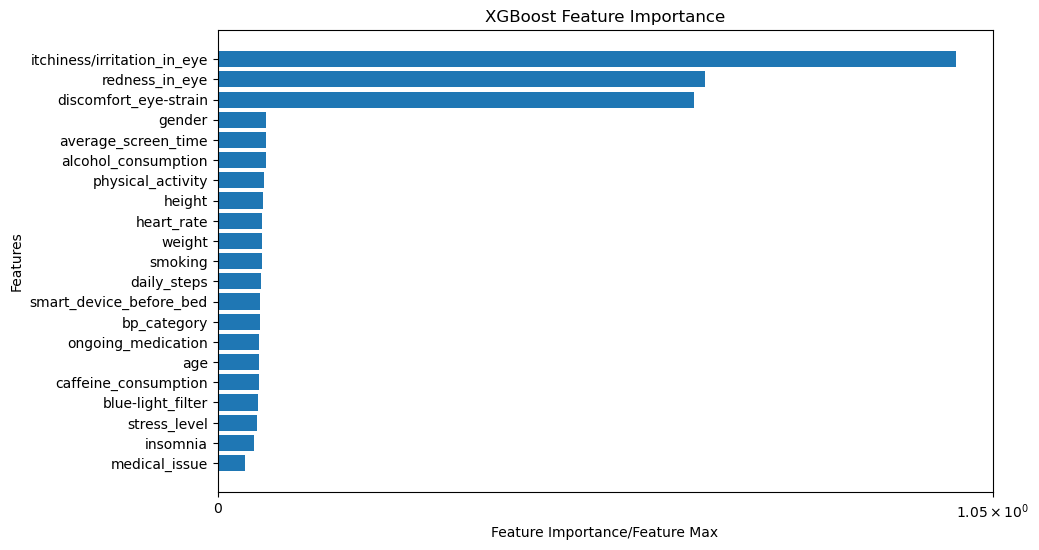

<Figure size 640x480 with 0 Axes>

In [49]:
feature_selection(df, 'dry_eye_disease')

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Test MSE: 0.24895302951335907
0.06586522


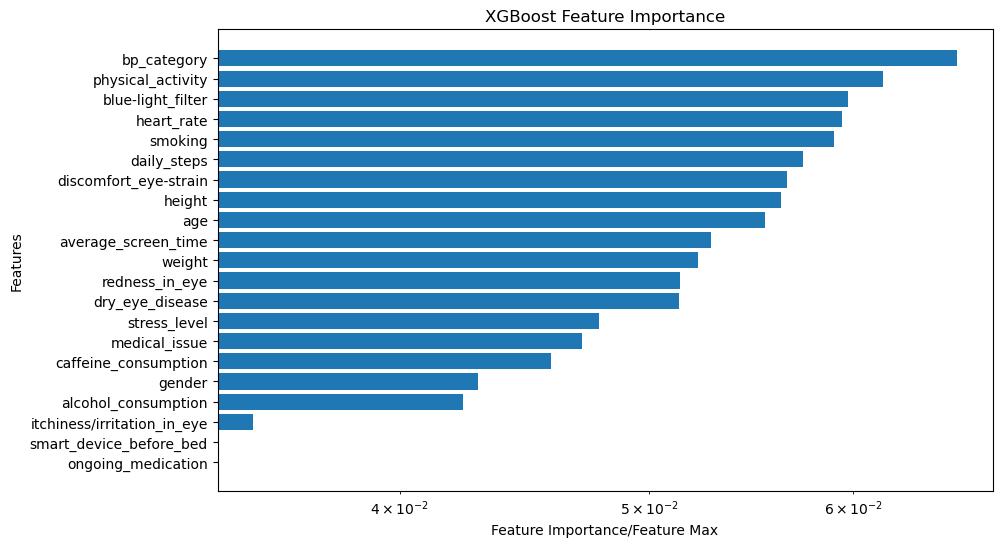

<Figure size 640x480 with 0 Axes>

In [9]:
feature_selection(df, 'insomnia')

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Test MSE: 0.20988300442695618
0.22145434


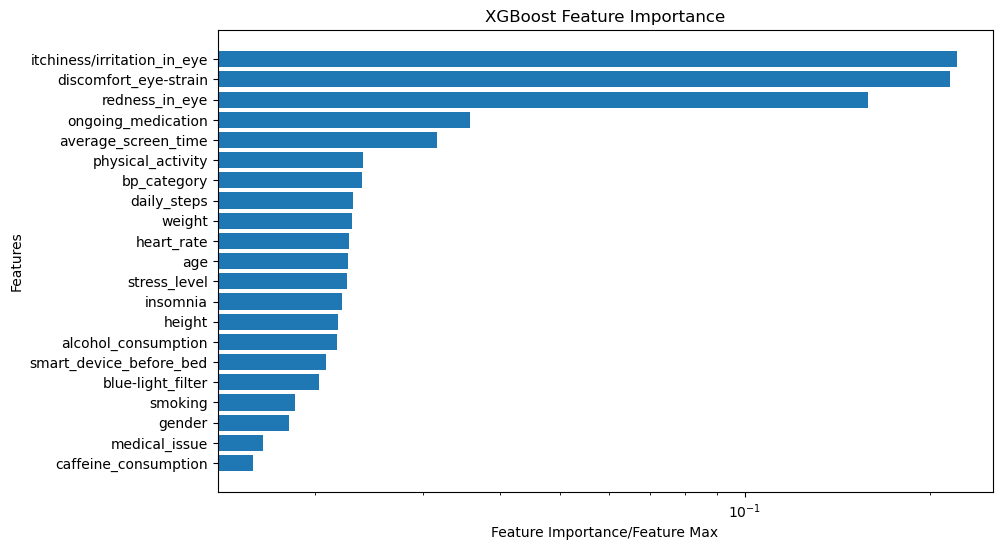

<Figure size 640x480 with 0 Axes>

In [12]:
feature_selection(df[df['age']<35], 'dry_eye_disease')

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Test MSE: 0.2105722725391388
0.34394175


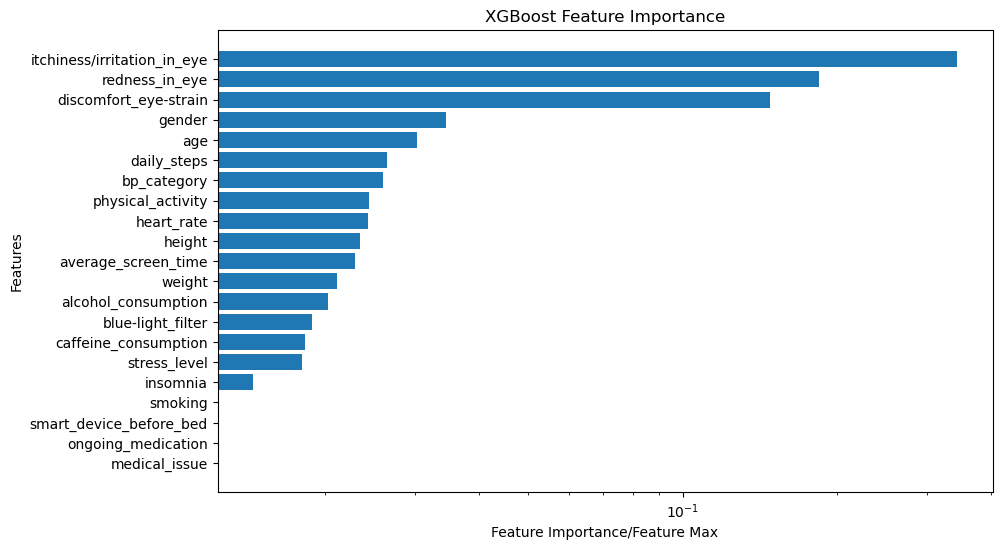

<Figure size 640x480 with 0 Axes>

In [13]:
feature_selection(df[df['age']>=35], 'dry_eye_disease')


np.float64(91.0)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Test MSE: 0.21589531004428864
0.21038973


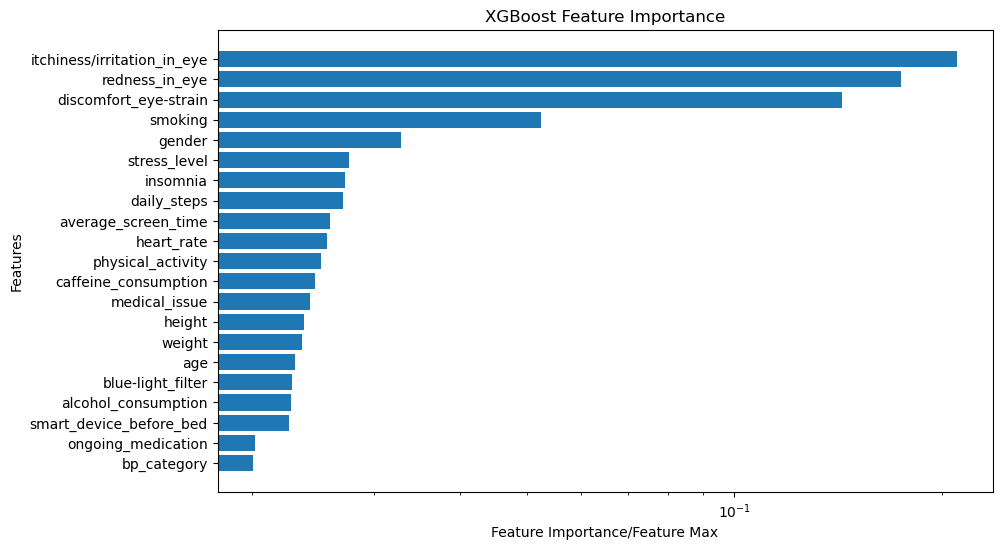

<Figure size 640x480 with 0 Axes>

In [18]:
feature_selection(df[df['physical_activity']<90], 'dry_eye_disease')